# Graph Mining - Final Project

Authors:
- Filippo Casagrande
- Jorge Morgado
- Hamed Aezami

## Importing necessary packages

We will use mainly:
- `networkx` for graph manipulation
- `sklearn` for classification metrics estimation
- `matplotlib` for plotting the results

In [35]:
import networkx as nx
import numpy as np

from pathlib import Path
from itertools import combinations

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

SEED = 42

## Loading the data

We define utility functions that will help us to load and parse the graphs

In [2]:
def load_graph_from_txt(file_path: str) -> list[nx.Graph]:
    graphs = [None for _ in range(8)]
    data = np.loadtxt(file_path, skiprows=1, dtype=float)
    data = data[:, -1]
    for i in range(8):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        adj_matrix = data[start_idx : end_idx].reshape(100, 100)
        for j in range(100):
            adj_matrix[j, j] = 0
        graphs[i] = nx.from_numpy_array(adj_matrix)
    return graphs


def load_graphs(folder: Path) -> list[list[nx.Graph]]:
    graphs = [None] * 248
    for file in folder.iterdir():
        print(f"Loading {file}", end="\r")
        idx = int(file.stem.split("_")[0]) - 1
        graphs[idx] = load_graph_from_txt(file)
    assert all(graph is not None for graph in graphs)
    return graphs

Then, we load all the graphs from each experiment set and label them accordingly

In [3]:
m_graphs = load_graphs(Path("./brain_networks/movie"))
s_graphs = load_graphs(Path("./brain_networks/story"))

In [4]:
for graphs in m_graphs:
    for G in graphs:
        G.graph["label"] = "movie"

for graphs in s_graphs:
    for G in graphs:
        G.graph["label"] = "story"

graphs = m_graphs + s_graphs

## Splitting the data

The next function will be used to split the dataset (similar to the `train_test_split` function from sklearn)

In [17]:
def train_test_split(
    graphs: list[list[nx.Graph]], train_size: float = 0.8, seed=None
) -> tuple[list[nx.Graph], list[str], list[nx.Graph], list[str]]:
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(graphs)
    train_idx = int(len(graphs) * train_size)
    return (
        graphs[:train_idx],
        [t_graphs[0].graph["label"] for t_graphs in graphs[:train_idx]],
        graphs[train_idx:],
        [t_graphs[0].graph["label"] for t_graphs in graphs[train_idx:]],
    )

Next, we split the dataset in train and test subsets

In [6]:
X_train, y_train, X_test, y_test = train_test_split(graphs, seed=SEED)

In [18]:
def split_by_label(graphs: list[list[nx.Graph]]) -> tuple[list[list[nx.Graph]], list[list[nx.Graph]]]:
    movie, story = [], []
    for t_graphs in graphs:
        if t_graphs[0].graph["label"] == "movie":
            movie.append(t_graphs)
        else:
            story.append(t_graphs)
    return movie, story

def get_graphs_at_time(graphs: list[list[nx.Graph]], time: int) -> list[nx.Graph]:
    return [t_graphs[time] for t_graphs in graphs]

## Classification according community detection

The classification algorithm we propose is based on community detection analysis.

Let $D$ be the set of experiments (8 graphs each), $L_i$ be the label of the $i$-th experiment (either movie or story), and $G_j^i$ be the graph of the $j$-th time stamp of the $i$-th experiment. For each graph on every time stamp on all the experiments we run a community detection algorithm, and then, for each experiment label, we build 8 graphs $A_1, ..., A_8$. Next we explain how each $A_k$ is built.

Each graph $A_k^m$ (and $A_k^s$ for the story experiments) contains 100 vertices (just as the dataset graphs). The value of each edge is defined as:

\begin{equation}
w(u,v) = \frac{\sum_{i=0}^{|D|} comm_k^i(u, v)}{|D|}
\end{equation}

where $|D|$ is the size of the dataset and $comm_k^i(u, v)$ is 1 if the edge $(u,v)$ if the vertices $u$ and $v$ belong to the same comunity in the $i$-th experiment at the $k$-th time stamp (0 if they were not in the same comunity).

Intuitivly, each $A_k$ edge contains the information of how likely are two nodes to be in the same comunity at the time $k$.

For classifying an unseen experiment, we run the same community detection algorithm for each time stamp graph $G_j$. Then, for each $G_j$ we sum the weights of the edges $(u, v)$ in each $A_j^m$ and $A_j^s$ if $u$ and $v$ were in the same community on $G_j$. Finally, we sum all the values of all the time stamps for each label, and depending on what was the label with the highest total value we classify the experiment accordingly.

The next function builds a graph $A_k^x$ given a set of graphs

In [22]:
def build_avg_community_graph(graphs: list[nx.Graph]) -> nx.Graph:
    adj_matrix = np.zeros((100, 100), dtype=float)
    for i, G in enumerate(graphs):
        print(f"Analyzing graph {i + 1} of {len(graphs)}        ", end="\r")
        communities = nx.community.greedy_modularity_communities(G, weight="weight")
        for community in communities:
            for u, v in combinations(community, 2):
                adj_matrix[u][v] += 1
                adj_matrix[v][u] += 1

    adj_matrix /= len(graphs)
    return nx.from_numpy_array(adj_matrix)

We then split the train set by the lables

In [23]:
X_train_movie, X_train_story = split_by_label(X_train)

avg_movie_graphs = [
    build_avg_community_graph(
        [t_graphs[t] for t_graphs in X_train_movie]
    )
    for t in range(8)
]

avg_story_graphs = [
    build_avg_community_graph(
        [t_graphs[t] for t_graphs in X_train_story]
    )
    for t in range(8)
]

The next function takes a new experiment and all the graphs $A_k^m$ and $A_k^s$ and makes a prediction of the experiment

In [57]:
def predict(
    t_graphs: list[nx.Graph], movie_t_avg: list[nx.Graph], story_t_avg: list[nx.Graph]
) -> str:
    movie_score = 0
    story_score = 0

    for t, G in enumerate(t_graphs[:4]):
        communities = nx.community.greedy_modularity_communities(G, weight="weight")
        for community in communities:
            for u, v in combinations(community, 2):
                movie_score += movie_t_avg[t].edges[u, v]["weight"]
                story_score += story_t_avg[t].edges[u, v]["weight"]

    return "movie" if movie_score > story_score else "story"

We then proceed to predict the label of all the experiments in the test set

In [58]:
y_pred, y_true = [], []

for t_graphs, label in zip(X_test, y_test):
    y_pred.append(
        predict(
            t_graphs,
            avg_movie_graphs,
            avg_story_graphs,
        )
    )
    y_true.append(label)

### Results report

In [59]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       movie       0.89      0.87      0.88        46
       story       0.89      0.91      0.90        54

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



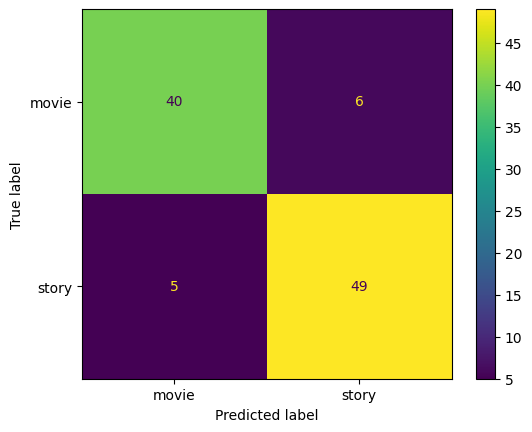

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=["movie", "story"])
disp.plot()
plt.show()

As we can see from the F1-score value, and the confusion matrix, by only leveraging a community detection algorithm we can obtain very good results predicting the type of the experiment.